## Data Loading



In [7]:
! cd

D:\GitHub repos\ml-debug-hackathon-2025


In [8]:
from azure.storage.filedatalake import DataLakeServiceClient

from dotenv import load_dotenv
import os

# Load environment variables from .env file
load_dotenv('notebooks/corrected/.env')

# Replace with your details
storage_account_name = "mldebugdevadls"
storage_account_key = os.getenv('AZURE_STORAGE_KEY')

# Connect to ADLS
service_client = DataLakeServiceClient(
    account_url=f"https://{storage_account_name}.dfs.core.windows.net",
    credential=storage_account_key,
    api_version="2023-11-03"  # Use the correct supported API version
)

# List Containers
containers = service_client.list_file_systems()
for container in containers:
    print(container.name)


data


In [9]:
# Replace with your details
container_name = 'data'

In [10]:
import os
from azure.storage.blob import BlobServiceClient
import pandas as pd
import io

def read_csv_from_blob(storage_account_name, container_name, file_name, storage_account_key=None):
    """
    Read a CSV file from Azure Blob Storage using Python and return a Pandas DataFrame.

    :param storage_account_name: Azure storage account name.
    :param container_name: Blob container name.
    :param file_name: Name of the file in the container.
    :param storage_account_key: Storage account access key.
    :return: Pandas DataFrame.
    """

    if not storage_account_key:
        # Try to get the key from environment variables if not provided
        storage_account_key = os.environ.get('AZURE_STORAGE_KEY')

    if not storage_account_key:
        raise ValueError("Storage account key must be provided either as a parameter or as an environment variable 'AZURE_STORAGE_KEY'")

    try:
        # Create a connection string
        connection_string = f"DefaultEndpointsProtocol=https;AccountName={storage_account_name};AccountKey={storage_account_key};EndpointSuffix=core.windows.net"

        # Create the BlobServiceClient
        blob_service_client = BlobServiceClient.from_connection_string(connection_string)

        # Get the container client
        container_client = blob_service_client.get_container_client(container_name)

        # Get the blob client
        blob_client = container_client.get_blob_client(file_name)

        # Download the blob content
        download_stream = blob_client.download_blob()

        # Convert the content to a DataFrame
        content = download_stream.readall()
        df = pd.read_csv(io.BytesIO(content))

        return df

    except Exception as e:
        print(f"Error reading CSV file: {e}")
        return None

In [85]:
online_marketing = read_csv_from_blob(storage_account_name=storage_account_name,
                                      container_name=container_name, 
                                      file_name="OnlineMarketingData.csv",
                                      storage_account_key=storage_account_key)
offline_marketing = read_csv_from_blob(storage_account_name=storage_account_name,
                                      container_name=container_name, 
                                      file_name="OfflineMarketingData.csv",
                                      storage_account_key=storage_account_key)
sales = read_csv_from_blob(storage_account_name=storage_account_name,
                                      container_name=container_name, 
                                      file_name="SalesData.csv",
                                      storage_account_key=storage_account_key)
price = read_csv_from_blob(storage_account_name=storage_account_name,
                                      container_name=container_name, 
                                      file_name="PricingData.csv",
                                      storage_account_key=storage_account_key)

## Importing Libraries

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm

## Data Pre Processing

In [13]:
# Read sales data and convert to date to datetime
sales['date'] =  pd.to_datetime(sales['date'])

#read offline marketing data and convert week to datetime
offline_marketing['week'] = pd.to_datetime(offline_marketing['week'])

#read online marketing data and convert to datetime
online_marketing['date'] = pd.to_datetime(online_marketing['date'])

In [14]:
# Calculate total daily sales to match with marketing data
daily_sales = sales.groupby('date')['sales_quantity'].sum().reset_index()
daily_sales.rename(columns={'sales_quantity': 'total_sales'}, inplace=True)

In [15]:
# Merge digital data with daily sales for analysis
digital_sales = pd.merge(online_marketing, daily_sales, on='date', how='left')

In [16]:
# Aggregate weekly sales for comparison with weekly media spend
weekly_sales = daily_sales.copy()
weekly_sales['week'] = pd.to_datetime(weekly_sales['date']).dt.to_period('W-SAT').dt.start_time
weekly_sales = weekly_sales.groupby('week')['total_sales'].sum().reset_index()

In [17]:
weekly_sales

,week,total_sales
0,2023-01-01,1005836
1,2023-01-08,1010621
2,2023-01-15,1007025
3,2023-01-22,1006524
4,2023-01-29,1004040
5,2023-02-05,1007593
6,2023-02-12,1002880
7,2023-02-19,1003058
8,2023-02-26,1003502
9,2023-03-05,1004209


In [18]:
offline_marketing

,week,channel,spend
0,2023-01-01,TV,11311.42
1,2023-01-01,Radio,6723.33
2,2023-01-01,Print,6214.43
3,2023-01-01,OOH,11230.47
4,2023-01-08,TV,14004.01
...,...,...,...
207,2023-12-24,OOH,14623.57
208,2023-12-31,TV,12565.47
209,2023-12-31,Radio,11167.25
210,2023-12-31,Print,9546.23


In [19]:
# Merge weekly media spend with weekly sales
media_sales = pd.merge(offline_marketing, weekly_sales, on='week', how='left')

In [20]:
media_sales

,week,channel,spend,total_sales
0,2023-01-01,TV,11311.42,1005836
1,2023-01-01,Radio,6723.33,1005836
2,2023-01-01,Print,6214.43,1005836
3,2023-01-01,OOH,11230.47,1005836
4,2023-01-08,TV,14004.01,1010621
...,...,...,...,...
207,2023-12-24,OOH,14623.57,1002768
208,2023-12-31,TV,12565.47,144434
209,2023-12-31,Radio,11167.25,144434
210,2023-12-31,Print,9546.23,144434


In [21]:
print(media_sales.head(25))

         week channel     spend  total_sales
0  2023-01-01      TV  11311.42      1005836
1  2023-01-01   Radio   6723.33      1005836
2  2023-01-01   Print   6214.43      1005836
3  2023-01-01     OOH  11230.47      1005836
4  2023-01-08      TV  14004.01      1010621
5  2023-01-08   Radio   9505.50      1010621
6  2023-01-08   Print  11069.60      1010621
7  2023-01-08     OOH  11380.75      1010621
8  2023-01-15      TV  14442.24      1007025
9  2023-01-15   Radio   7836.04      1007025
10 2023-01-15   Print   8861.17      1007025
11 2023-01-15     OOH  10270.30      1007025
12 2023-01-22      TV  11917.89      1006524
13 2023-01-22   Radio   6663.51      1006524
14 2023-01-22   Print  11601.91      1006524
15 2023-01-22     OOH   8335.56      1006524
16 2023-01-29      TV   6753.84      1004040
17 2023-01-29   Radio  12158.00      1004040
18 2023-01-29   Print   7488.18      1004040
19 2023-01-29     OOH   9575.21      1004040
20 2023-02-05      TV   8881.09      1007593
21 2023-02

## Task 1: Flawed Adstock Transformation

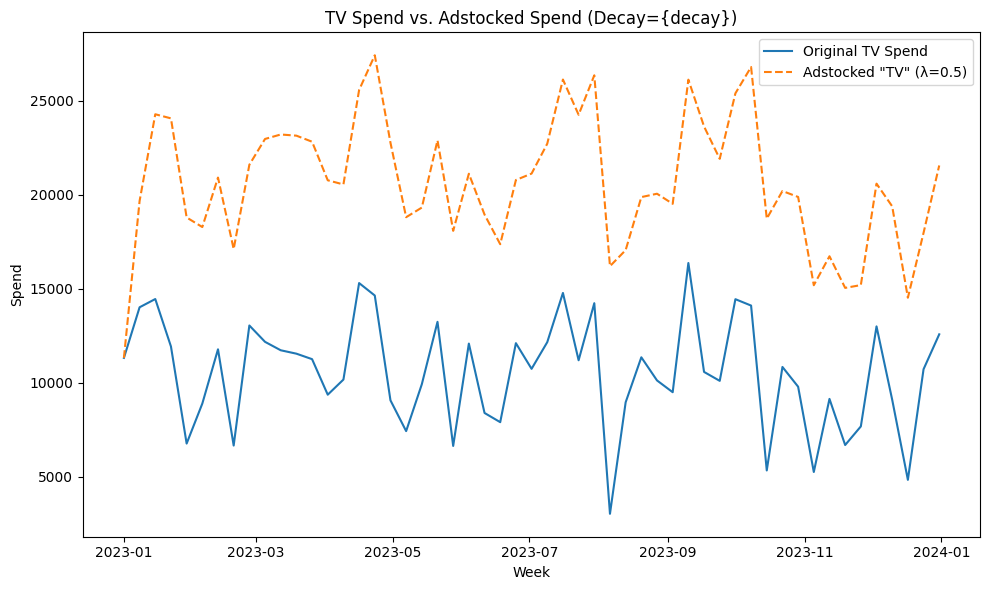

In [22]:
def plot_adstock_corrected(decay=0.5):
    # Filter the media data to get only TV spend
    media_df = offline_marketing[offline_marketing['channel'] == 'TV'][['week', 'spend']].copy()

    # Rename 'spend' column to 'TV' for consistency
    media_df['TV'] = media_df['spend']

    adstock_vals = []
    for i, spend in enumerate(media_df["TV"]):
        if i == 0:
            # initial adstock equals the first spend
            adstock_vals.append(spend)
        else:
            # current adstock = current spend + decay * previous adstock
            adstock_vals.append(spend + decay * adstock_vals[i-1])
    
    media_df['TV_adstock'] = adstock_vals
    
    # 3) Plot
    plt.figure(figsize=(10, 6))
    plt.plot(media_df['week'], media_df["TV"], label=f'Original TV Spend')
    plt.plot(media_df['week'], media_df['TV_adstock'],
             label=f'Adstocked "TV" (λ={decay})', linestyle='--')
    plt.title('TV Spend vs. Adstocked Spend (Decay={decay})')
    plt.xlabel('Week')
    plt.ylabel('Spend')
    plt.legend()
    plt.tight_layout()
    plt.show()


plot_adstock_corrected()




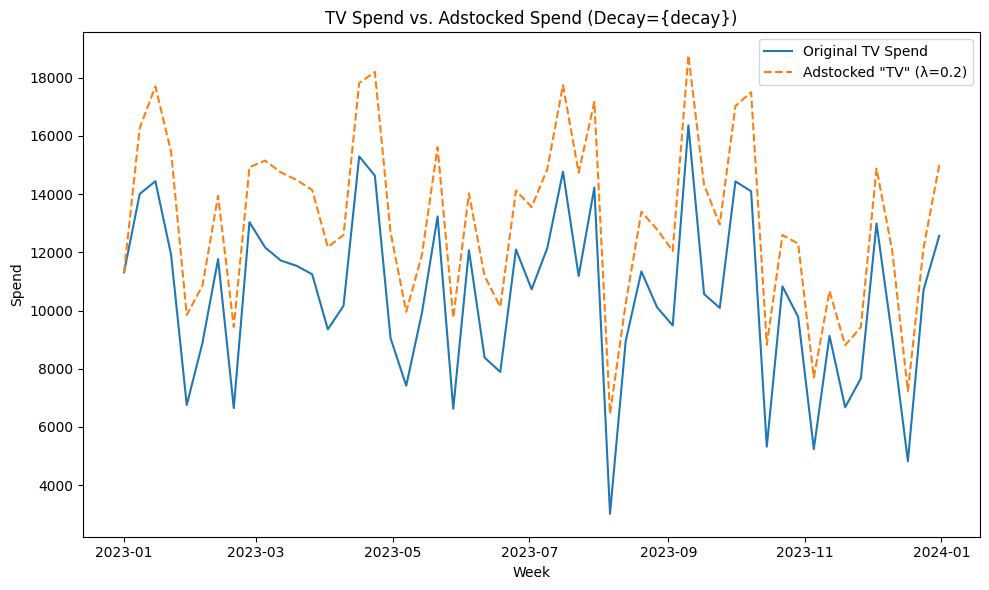

In [23]:
plot_adstock_corrected(decay=0.2)

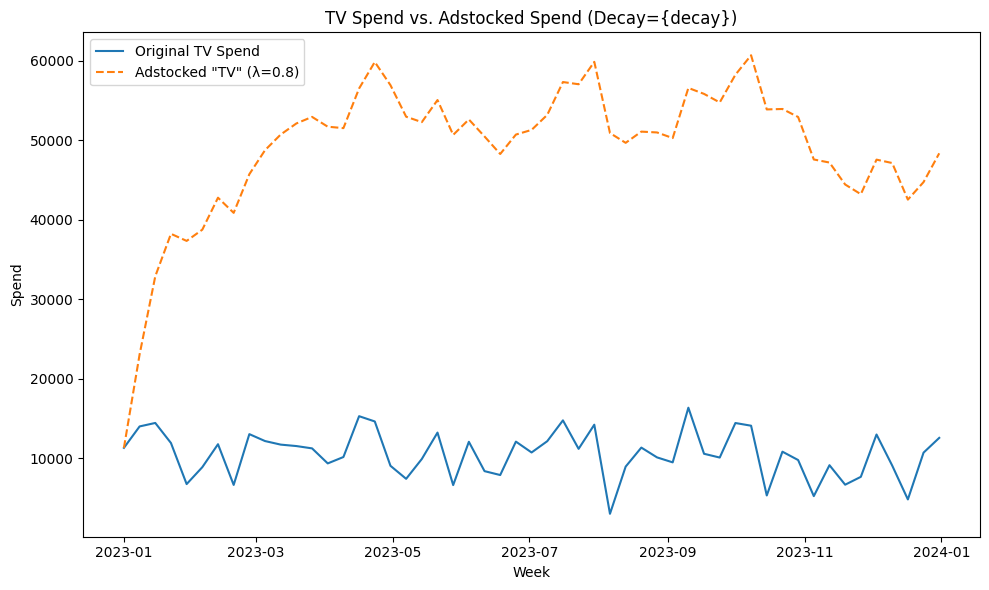

In [24]:
plot_adstock_corrected(decay=0.8)

## Task 2: Misleading Diminishing Returns Visualization (No Saturation Effect)

In [25]:
print(offline_marketing.head(25))

         week channel     spend
0  2023-01-01      TV  11311.42
1  2023-01-01   Radio   6723.33
2  2023-01-01   Print   6214.43
3  2023-01-01     OOH  11230.47
4  2023-01-08      TV  14004.01
5  2023-01-08   Radio   9505.50
6  2023-01-08   Print  11069.60
7  2023-01-08     OOH  11380.75
8  2023-01-15      TV  14442.24
9  2023-01-15   Radio   7836.04
10 2023-01-15   Print   8861.17
11 2023-01-15     OOH  10270.30
12 2023-01-22      TV  11917.89
13 2023-01-22   Radio   6663.51
14 2023-01-22   Print  11601.91
15 2023-01-22     OOH   8335.56
16 2023-01-29      TV   6753.84
17 2023-01-29   Radio  12158.00
18 2023-01-29   Print   7488.18
19 2023-01-29     OOH   9575.21
20 2023-02-05      TV   8881.09
21 2023-02-05   Radio   8960.04
22 2023-02-05   Print   4697.08
23 2023-02-05     OOH  12255.92
24 2023-02-12      TV  11767.96


In [26]:
weekly_sales

,week,total_sales
0,2023-01-01,1005836
1,2023-01-08,1010621
2,2023-01-15,1007025
3,2023-01-22,1006524
4,2023-01-29,1004040
5,2023-02-05,1007593
6,2023-02-12,1002880
7,2023-02-19,1003058
8,2023-02-26,1003502
9,2023-03-05,1004209


C:\Users\Omkar\AppData\Local\Temp\ipykernel_10168\4204686667.py:5: RuntimeWarning: invalid value encountered in scalar power
  return Vmax * (x ** alpha) / (x ** alpha + K ** alpha)


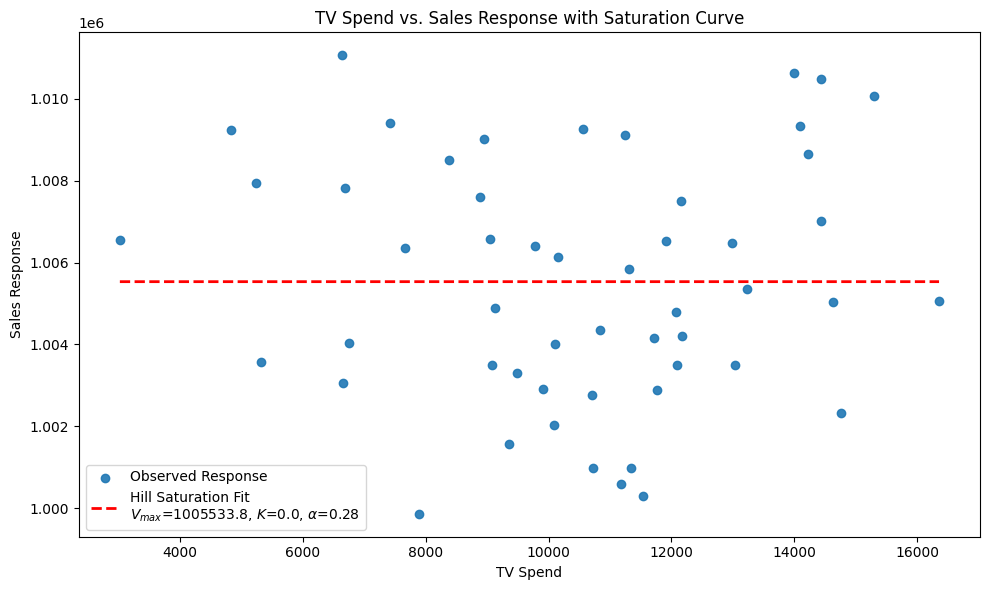

In [27]:

from scipy.optimize import curve_fit

# Define the Hill saturation function
def hill_response(x, Vmax, K, alpha):
    return Vmax * (x ** alpha) / (x ** alpha + K ** alpha)

def plot_diminishing_returns_corrected(offline_marketing, actual_sales):
    x_data = offline_marketing[offline_marketing['channel'] == 'TV']['spend'].values
    y_data = actual_sales['total_sales'].values
    
    # Fit the Hill model
    p0 = [max(y_data), np.median(x_data), 1.0]
    params, cov = curve_fit(hill_response, x_data, y_data, p0=p0, maxfev=10_0000)

    Vmax_fit, K_fit, alpha_fit = params
    
    x_range = np.linspace(x_data.min(), x_data.max(), 50)
    y_hat = hill_response(x_range, Vmax_fit, K_fit, alpha_fit)
    
    plt.figure(figsize=(10, 6))
    plt.scatter(x_data, y_data, label='Observed Response', alpha=0.9)
    plt.plot(x_range, y_hat, 'r--', lw=2,
            label=f'Hill Saturation Fit\n$V_{{max}}$={Vmax_fit:.1f}, $K$={K_fit:.1f}, $\\alpha$={alpha_fit:.2f}')
    plt.title('TV Spend vs. Sales Response with Saturation Curve')
    plt.xlabel('TV Spend')
    plt.ylabel('Sales Response')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
plot_diminishing_returns_corrected(
    offline_marketing[offline_marketing['channel'] == 'TV'][:-1],
    weekly_sales[:-1]
)


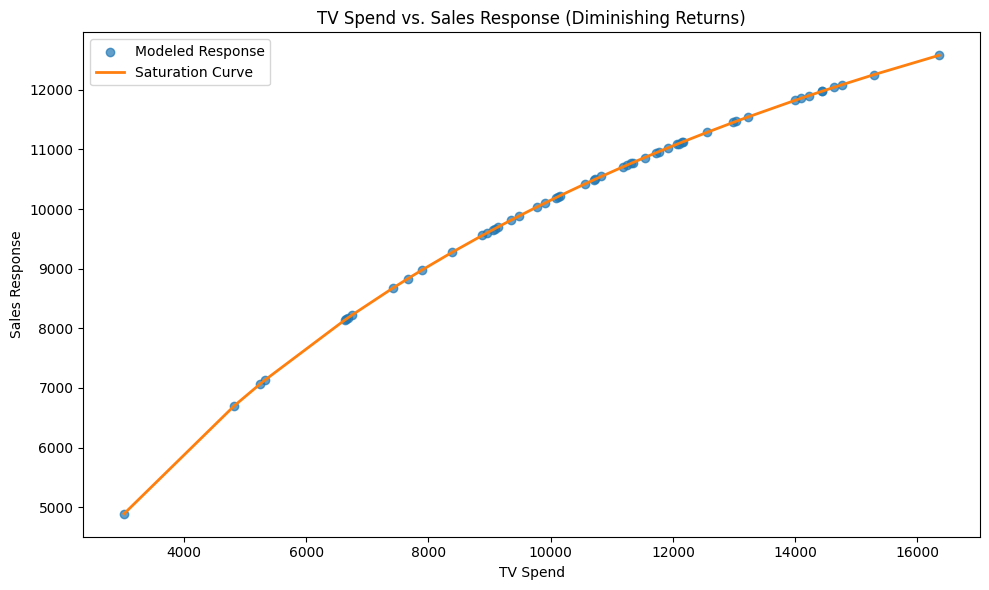

In [28]:

def plot_adstock_corrected():
  
    tv_spend = offline_marketing[offline_marketing['channel'] == 'TV']['spend'].values

    # Parameters for the saturation curve
    # baseline response, maximum lift, and half‐saturation constant
    baseline = 500
    max_lift = 20000
    k = np.median(tv_spend)  # spend at which response is half of max_lift

    # Saturation curve: response = baseline + max_lift * (tv_spend / (tv_spend + k))
    response = baseline + max_lift * (tv_spend / (tv_spend + k))

    # For a smooth trend line, sort by spend
    sort_idx = np.argsort(tv_spend)
    tv_sorted = tv_spend[sort_idx]
    resp_sorted = response[sort_idx]

    # Plot the scatter plot
    plt.figure(figsize=(10, 6))
    plt.scatter(tv_spend, response, color='C0', alpha=0.7, label='Modeled Response')

    # Plot the saturation curve
    plt.plot(tv_sorted, resp_sorted, color='C1', lw=2, label='Saturation Curve')

    # Add titles and labels
    plt.title('TV Spend vs. Sales Response (Diminishing Returns)')
    plt.xlabel('TV Spend')
    plt.ylabel('Sales Response')
    plt.legend()
    plt.tight_layout()
    plt.show()
plot_adstock_corrected()


## Task 3: Incorrect Assessment of Interaction Term in Sales Analysis

In [86]:
offline_channels = ['TV', 'Radio', 'Print', 'OOH']
online_channels = ['Facebook', 'Instagram', 'YouTube', 'Google Ads', 'Influencer Marketing']

In [87]:
online_df = online_marketing.copy()
offline_df = offline_marketing.copy()

In [88]:
online_df['date'] = pd.to_datetime(online_df['date'], format='%Y-%m-%d')
online_df['week'] = pd.to_datetime(online_df['date']).dt.to_period('W-SAT').dt.start_time
online_df['week'] = pd.to_datetime(online_df['week'], format='%Y-%m-%d')

online_media_weekly_df = online_df.drop(['date'], axis=1)
online_media_weekly_df = online_media_weekly_df.groupby(['week', 'channel']).sum().reset_index()
online_media_weekly_df

,week,channel,spend,impressions,clicks
0,2023-01-01,Facebook,7658.48,122072,3445
1,2023-01-01,Google Ads,6838.90,111271,3073
2,2023-01-01,Influencer Marketing,6900.80,101912,2904
3,2023-01-01,Instagram,6542.48,85078,2559
4,2023-01-01,YouTube,6460.78,109825,3735
...,...,...,...,...,...
260,2023-12-31,Facebook,914.14,14909,233
261,2023-12-31,Google Ads,966.66,17766,777
262,2023-12-31,Influencer Marketing,1135.69,21297,558
263,2023-12-31,Instagram,1235.49,21998,578


In [90]:
offline_marketing_df = offline_marketing.copy()
offline_marketing_df['week'] = pd.to_datetime(offline_marketing_df['week'], format='%Y-%m-%d')

In [91]:
media_sales = pd.merge(online_media_weekly_df, offline_marketing_df, on=['week', 'channel'], how='outer', suffixes=('_online', '_offline'))
media_sales.fillna(0, inplace=True)

In [92]:
df = media_sales.copy()
online_spend = (
    df[df["spend_online"] > 0]
    # .pivot_table(index="week", columns="channel", values="spend_online", aggfunc="sum")
    # .add_prefix("spend_online_")
).rename(columns={"spend_online": "spend"}).drop(columns=["clicks", "impressions", "spend_offline"])

#    b) Offline spend by channel
offline_spend = (
    df[df["spend_offline"] > 0]
    # .pivot_table(index="week", columns="channel", values="spend_offline", aggfunc="sum")
    # .add_prefix("spend_offline_")
).rename(columns={"spend_offline": "spend"}).drop(columns=["clicks", "impressions", "spend_online"])

In [93]:
online_spend

,week,channel,spend
0,2023-01-01,Facebook,7658.48
1,2023-01-01,Google Ads,6838.90
2,2023-01-01,Influencer Marketing,6900.80
3,2023-01-01,Instagram,6542.48
8,2023-01-01,YouTube,6460.78
...,...,...,...
468,2023-12-31,Facebook,914.14
469,2023-12-31,Google Ads,966.66
470,2023-12-31,Influencer Marketing,1135.69
471,2023-12-31,Instagram,1235.49


In [94]:
offline_spend

,week,channel,spend
4,2023-01-01,OOH,11230.47
5,2023-01-01,Print,6214.43
6,2023-01-01,Radio,6723.33
7,2023-01-01,TV,11311.42
13,2023-01-08,OOH,11380.75
...,...,...,...
466,2023-12-24,TV,10709.13
472,2023-12-31,OOH,9881.73
473,2023-12-31,Print,9546.23
474,2023-12-31,Radio,11167.25


In [95]:
# concatenate online and offline spend dataframes
media_spend = pd.concat([online_spend, offline_spend], axis=0).sort_values(by='week').reset_index(drop=True)
media_spend

,week,channel,spend
0,2023-01-01,Facebook,7658.48
1,2023-01-01,Print,6214.43
2,2023-01-01,OOH,11230.47
3,2023-01-01,TV,11311.42
4,2023-01-01,Radio,6723.33
...,...,...,...
472,2023-12-31,Facebook,914.14
473,2023-12-31,Google Ads,966.66
474,2023-12-31,Influencer Marketing,1135.69
475,2023-12-31,Radio,11167.25


In [97]:
sales_df = sales.copy()
sales_df['date'] = pd.to_datetime(sales_df['date'], format='%Y-%m-%d')
sales_df['week'] = pd.to_datetime(sales_df['date']).dt.to_period('W-SAT').dt.start_time
weekly_sales_df = sales_df.groupby('week')['sales_quantity'].sum().reset_index()
weekly_sales_df


,week,sales_quantity
0,2023-01-01,1005836
1,2023-01-08,1010621
2,2023-01-15,1007025
3,2023-01-22,1006524
4,2023-01-29,1004040
5,2023-02-05,1007593
6,2023-02-12,1002880
7,2023-02-19,1003058
8,2023-02-26,1003502
9,2023-03-05,1004209


In [98]:
media_sales = pd.merge(media_spend, weekly_sales_df, on='week', how='left')
media_sales


,week,channel,spend,sales_quantity
0,2023-01-01,Facebook,7658.48,1005836
1,2023-01-01,Print,6214.43,1005836
2,2023-01-01,OOH,11230.47,1005836
3,2023-01-01,TV,11311.42,1005836
4,2023-01-01,Radio,6723.33,1005836
...,...,...,...,...
472,2023-12-31,Facebook,914.14,144434
473,2023-12-31,Google Ads,966.66,144434
474,2023-12-31,Influencer Marketing,1135.69,144434
475,2023-12-31,Radio,11167.25,144434


In [99]:
media_sales.rename(columns={'sales_quantity': 'total_sales'}, inplace=True)

In [102]:
print(media_sales.head(25))

         week               channel     spend  total_sales
0  2023-01-01              Facebook   7658.48      1005836
1  2023-01-01                 Print   6214.43      1005836
2  2023-01-01                   OOH  11230.47      1005836
3  2023-01-01                    TV  11311.42      1005836
4  2023-01-01                 Radio   6723.33      1005836
5  2023-01-01             Instagram   6542.48      1005836
6  2023-01-01  Influencer Marketing   6900.80      1005836
7  2023-01-01            Google Ads   6838.90      1005836
8  2023-01-01               YouTube   6460.78      1005836
9  2023-01-08              Facebook   7392.16      1010621
10 2023-01-08            Google Ads   7631.45      1010621
11 2023-01-08  Influencer Marketing   7247.63      1010621
12 2023-01-08             Instagram   6773.16      1010621
13 2023-01-08               YouTube   6754.75      1010621
14 2023-01-08                    TV  14004.01      1010621
15 2023-01-08                 Radio   9505.50      10106

In [103]:
import pandas as pd
import numpy as np

# Assuming 'media_sales' is your DataFrame
# Define online and offline channels
online_channels = ['Facebook', 'Instagram', 'Influencer Marketing', 'Google Ads', 'YouTube']
offline_channels = ['TV', 'Radio', 'Print', 'OOH']

# Pivot the data
media_sales_pivoted = media_sales.pivot_table(index='week', columns='channel', values='spend', aggfunc='sum').fillna(0)

# Calculate total online and offline spends
media_sales_pivoted['online_spend'] = media_sales_pivoted[online_channels].sum(axis=1)
media_sales_pivoted['offline_spend'] = media_sales_pivoted[offline_channels].sum(axis=1)

# Merge total_sales
total_sales = media_sales[['week', 'total_sales']].drop_duplicates()
media_sales_pivoted = media_sales_pivoted.merge(total_sales, on='week', how='left')


In [108]:
media_sales_pivoted

,week,Facebook,Google Ads,Influencer Marketing,Instagram,OOH,Print,Radio,TV,YouTube,online_spend,offline_spend,total_sales
0,2023-01-01,7658.48,6838.90,6900.80,6542.48,11230.47,6214.43,6723.33,11311.42,6460.78,34401.44,35479.65,1005836
1,2023-01-08,7392.16,7631.45,7247.63,6773.16,11380.75,11069.60,9505.50,14004.01,6754.75,35799.15,45959.86,1010621
2,2023-01-15,7356.63,6004.55,7953.68,7765.96,10270.30,8861.17,7836.04,14442.24,7846.51,36927.33,41409.75,1007025
3,2023-01-22,7237.25,7145.31,7162.25,7300.00,8335.56,11601.91,6663.51,11917.89,7395.38,36240.19,38518.87,1006524
4,2023-01-29,6386.66,5924.19,6804.07,6157.35,9575.21,7488.18,12158.00,6753.84,6489.35,31761.62,35975.23,1004040
5,2023-02-05,7564.30,6068.33,6883.89,6921.18,12255.92,4697.08,8960.04,8881.09,7269.20,34706.90,34794.13,1007593
6,2023-02-12,7832.26,7136.55,7285.74,6805.30,6348.65,3987.37,8863.17,11767.96,6840.69,35900.54,30967.15,1002880
7,2023-02-19,6347.22,7954.75,7052.08,7359.33,9698.83,9648.21,13535.80,6648.19,7395.30,36108.68,39531.03,1003058
8,2023-02-26,6957.77,7747.18,7191.43,7461.92,3847.06,12065.73,7152.14,13035.47,6829.39,36187.69,36100.40,1003502
9,2023-03-05,7091.48,5944.91,6524.63,7677.08,10679.14,12388.97,14007.00,12165.05,6908.30,34146.40,49240.16,1004209


In [104]:
import statsmodels.api as sm

# Log-transform the variables
media_sales_pivoted['log_online'] = np.log(media_sales_pivoted['online_spend'] + 1)
media_sales_pivoted['log_offline'] = np.log(media_sales_pivoted['offline_spend'] + 1)
media_sales_pivoted['log_sales'] = np.log(media_sales_pivoted['total_sales'] + 1)

# Create interaction term
media_sales_pivoted['interaction'] = media_sales_pivoted['log_online'] * media_sales_pivoted['log_offline']

# Define independent variables and add constant
X = media_sales_pivoted[['log_online', 'log_offline', 'interaction']]
X = sm.add_constant(X)

# Define dependent variable
y = media_sales_pivoted['log_sales']

# Fit the model
model = sm.OLS(y, X).fit()

# Display the summary
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:              log_sales   R-squared:                       0.991
Model:                            OLS   Adj. R-squared:                  0.991
Method:                 Least Squares   F-statistic:                     1897.
Date:                Sun, 25 May 2025   Prob (F-statistic):           1.17e-50
Time:                        13:15:25   Log-Likelihood:                 121.61
No. Observations:                  53   AIC:                            -235.2
Df Residuals:                      49   BIC:                            -227.3
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const         513.2357     79.460      6.459      

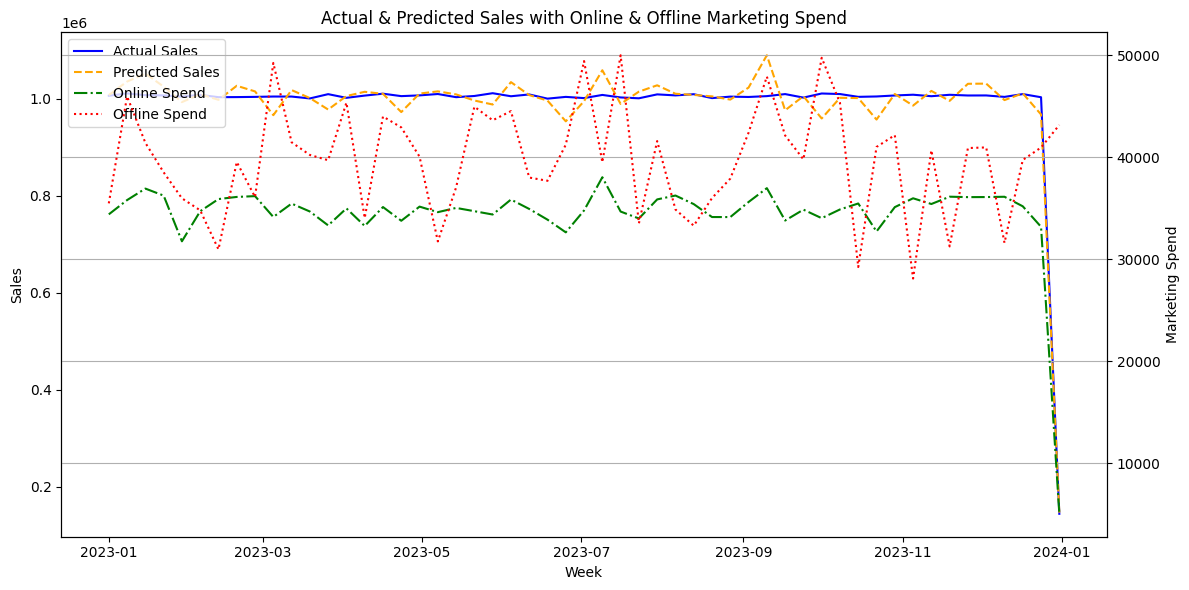

In [117]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm


# Define online and offline channels
online_channels = ['Facebook', 'Instagram', 'Influencer Marketing', 'Google Ads', 'YouTube']
offline_channels = ['TV', 'Radio', 'Print', 'OOH']

# Pivot the data
media_sales_pivoted = media_sales.pivot_table(index='week', columns='channel', values='spend', aggfunc='sum').fillna(0)

# Calculate total online and offline spends
media_sales_pivoted['online_spend'] = media_sales_pivoted[online_channels].sum(axis=1)
media_sales_pivoted['offline_spend'] = media_sales_pivoted[offline_channels].sum(axis=1)

# Merge total_sales
total_sales = media_sales[['week', 'total_sales']].drop_duplicates()
media_sales_pivoted = media_sales_pivoted.merge(total_sales, on='week', how='left')

# Convert 'week' to datetime
media_sales_pivoted['week'] = pd.to_datetime(media_sales_pivoted['week'])

# Sort by week
media_sales_pivoted.sort_values('week', inplace=True)

# Log-transform the variables
media_sales_pivoted['log_online'] = np.log(media_sales_pivoted['online_spend'] + 1)
media_sales_pivoted['log_offline'] = np.log(media_sales_pivoted['offline_spend'] + 1)
media_sales_pivoted['log_sales'] = np.log(media_sales_pivoted['total_sales'] + 1)

# Create interaction term
media_sales_pivoted['interaction'] = media_sales_pivoted['log_online'] * media_sales_pivoted['log_offline']

# Define independent variables and add constant
X = media_sales_pivoted[['log_online', 'log_offline', 'interaction']]
X = sm.add_constant(X)

# Define dependent variable
y = media_sales_pivoted['log_sales']

# Fit the model
model = sm.OLS(y, X).fit()

def corrected_interaction_analysis():
  
  # Predict log sales and convert back to original scale
  media_sales_pivoted['predicted_log_sales'] = model.predict(X)
  media_sales_pivoted['predicted_sales'] = np.exp(media_sales_pivoted['predicted_log_sales']) - 1

  # Create the plot
  fig, ax1 = plt.subplots(figsize=(12, 6))

  # Plot actual and predicted sales on the primary y-axis
  ax1.set_xlabel('Week')
  ax1.set_ylabel('Sales')
  ax1.plot(media_sales_pivoted['week'], media_sales_pivoted['total_sales'], color='blue', label='Actual Sales')
  ax1.plot(media_sales_pivoted['week'], media_sales_pivoted['predicted_sales'], color='orange', linestyle='--', label='Predicted Sales')
  ax1.tick_params(axis='y')

  # Create a secondary y-axis
  ax2 = ax1.twinx()

  # Plot online and offline spends on the secondary y-axis
  ax2.set_ylabel('Marketing Spend')
  ax2.plot(media_sales_pivoted['week'], media_sales_pivoted['online_spend'], color='green', linestyle='-.', label='Online Spend')
  ax2.plot(media_sales_pivoted['week'], media_sales_pivoted['offline_spend'], color='red', linestyle=':', label='Offline Spend')
  ax2.tick_params(axis='y')

  # Combine legends from both axes
  lines_1, labels_1 = ax1.get_legend_handles_labels()
  lines_2, labels_2 = ax2.get_legend_handles_labels()
  ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')

  # Add title and grid
  plt.title('Actual & Predicted Sales with Online & Offline Marketing Spend')
  plt.grid(True)
  plt.tight_layout()
  plt.show()

corrected_interaction_analysis()


## Task 4: Modeling and Visualizing the Adstock Effect

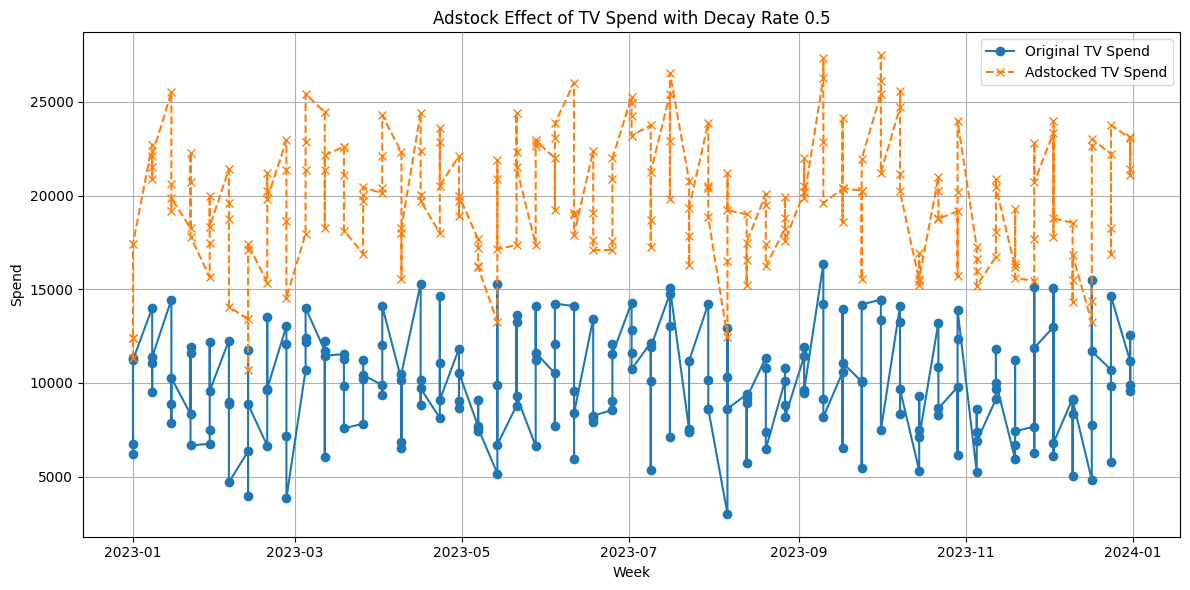

In [ ]:
def compute_adstock(spend_series, decay_rate):
    """
    Applies the adstock transformation using geometric decay.
    """
    adstocked = np.zeros(len(spend_series))
    adstocked[0] = spend_series.iloc[0]

    for i in range(1, len(spend_series)):
        adstocked[i] = spend_series.iloc[i] + decay_rate * adstocked[i-1]

    return pd.Series(adstocked, index=spend_series.index)

def plot_adstock_effect_corrected(sales, offline_marketing, decay_rate=0.5):
    """
    Calculates and plots the corrected adstock effect on media spend over time.
    """
    # Aggregate daily sales to weekly
    daily_sales = sales.groupby('date')['sales_quantity'].sum().reset_index()
    daily_sales['week'] = pd.to_datetime(daily_sales['date']).dt.to_period('W-SAT').dt.start_time
    weekly_sales = daily_sales.groupby('week')['sales_quantity'].sum().reset_index()
    weekly_sales.rename(columns={'sales_quantity': 'total_sales'}, inplace=True)

    # Format weeks
    offline_marketing['week'] = pd.to_datetime(offline_marketing['week'], format='%Y-%m-%d')
    weekly_sales['week'] = pd.to_datetime(weekly_sales['week'], format='%Y-%m-%d')

    # Merge and sort
    media_sales = pd.merge(offline_marketing, weekly_sales, on='week', how='left')
    media_sales.sort_values('week', inplace=True)

    # Apply adstock
    media_sales['TV'] = media_sales['spend']
    media_sales['TV_adstock'] = compute_adstock(media_sales['TV'], decay_rate)

    # Plotting
    plt.figure(figsize=(12, 6))
    plt.plot(media_sales['week'], media_sales['TV'], label='Original TV Spend', marker='o')
    plt.plot(media_sales['week'], media_sales['TV_adstock'], label='Adstocked TV Spend', marker='x', linestyle='--')
    plt.title(f'Adstock Effect of TV Spend with Decay Rate {decay_rate}')
    plt.xlabel('Week')
    plt.ylabel('Spend')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_adstock_effect_corrected(sales, offline_marketing, decay_rate=0.5)

In [124]:
media_sales

,week,channel,spend,total_sales
0,2023-01-01,Facebook,7658.48,1005836
1,2023-01-01,Print,6214.43,1005836
2,2023-01-01,OOH,11230.47,1005836
3,2023-01-01,TV,11311.42,1005836
4,2023-01-01,Radio,6723.33,1005836
...,...,...,...,...
472,2023-12-31,Facebook,914.14,144434
473,2023-12-31,Google Ads,966.66,144434
474,2023-12-31,Influencer Marketing,1135.69,144434
475,2023-12-31,Radio,11167.25,144434
